In [1]:
# !pip install

# Import

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error

# CONFIG

In [2]:
data_dir = '../ABI_Data'
data_load_from_file = False
pickle_path = './dataframe.pkl'
pickle_create = False
pickle_load = False

num_epochs = 50
batch_size = 16
train_proportion = .8
val_proportion = .1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Code

In [4]:
if data_load_from_file or pickle_create:
    print("Files start")
    files = [f for f in os.listdir(data_dir) if f.endswith('.npz')][:100]
    print("Files done")
    
    records = []
    print("Records start")
    for file in tqdm(files):
        path = os.path.join(data_dir, file)
        try:
            data = np.load(path)
            records.extend([{k: arr[i] for k, arr in data.items()} for i in range(len(next(iter(data.values()))))])
            # print(f"Loaded: {file}")
        except Exception as e:
            print(f"Failed to load: {file} : {e}")
            pass
    
    print("DF start")
    df = pd.DataFrame(records)
    print("DF done")
    if pickle_create:
        print("Starting pickle")
        df.to_pickle(pickle_path)
        print(f"Pickle saved to: {pickle_path}")
        
if pickle_load:
    print("Loading Pickle")
    df = pd.read_pickle('dataframe.pkl')
    print("Pickle Loaded")

Loading Pickle
Pickle Loaded


In [5]:
# def print_column_info(df):
#     for col in df.columns:
#         dtype = df[col].dtype
#         sample = df[col].dropna().iloc[0] if not df[col].dropna().empty else "NaN"
#         print(f"{col}: {dtype}, sample: {sample}")
# print_column_info(df)


In [6]:
df = df.dropna(subset=['l2_cloud_mask', 'l2_cloud_phase', 'l2_cod', 'l2_cps'])
print(f"Remaining samples after dropping NaNs: {len(df)}")

Remaining samples after dropping NaNs: 12800


In [7]:
def preprocess(df):
    # Inputs: stack rad arrays (N samples, 128 rows, 16 channels)
    # We want shape (N, channels=16, height=128)
    rad_np = np.stack(df['rad'].values)  # shape (N, 128, 16)
    X = torch.tensor(rad_np, dtype=torch.float32).permute(0, 2, 1)  # (N, 16, 128)
    
    # Targets: stack and convert
    y_mask = torch.tensor(np.stack(df['l2_cloud_mask'].values), dtype=torch.long)    # (N, 128)
    y_phase = torch.tensor(np.stack(df['l2_cloud_phase'].values), dtype=torch.long)  # (N, 128)
    y_cod = torch.tensor(np.stack(df['l2_cod'].values), dtype=torch.float32)         # (N, 128)
    y_cps = torch.tensor(np.stack(df['l2_cps'].values), dtype=torch.float32)         # (N, 128)
    
    return X, y_mask, y_phase, y_cod, y_cps

X, y_mask, y_phase, y_cod, y_cps = preprocess(df)

In [8]:
class MultiTaskModel(nn.Module):
    def __init__(self, in_channels=16, seq_length=128):
        super().__init__()
        
        # Shared feature extractor (1D Conv layers)
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.dropout = nn.Dropout(0.3)
        
        # Heads for each task:
        # Classification tasks output logits for each class per position
        # Assuming l2_cloud_mask and l2_cloud_phase are classes with known number of classes:
        self.mask_head = nn.Conv1d(256, 2, kernel_size=1)  # 2 classes: mask/no-mask
        self.phase_head = nn.Conv1d(256, 5, kernel_size=1)
        
        # Regression tasks output a single float per position
        self.cod_head = nn.Conv1d(256, 1, kernel_size=1)
        self.cps_head = nn.Conv1d(256, 1, kernel_size=1)
        
    def forward(self, x):
        # x: (batch, channels=16, length=128)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        
        # Heads
        mask_logits = self.mask_head(x)
        phase_logits = self.phase_head(x)
        
        cod_pred = self.cod_head(x).squeeze(1)
        cps_pred = self.cps_head(x).squeeze(1)
        
        return mask_logits, phase_logits, cod_pred, cps_pred

In [9]:
# model = MultiTaskModel()

# # Example input batch
# # X shape: (batch_size, 16, 128)
# X = torch.randn(4, 16, 128)

# mask_logits, phase_logits, cod_pred, cps_pred = model(X)
# print(mask_logits.shape)  # (4, 128)
# print(phase_logits.shape) # (4, 128)
# print(cod_pred.shape)     # (4, 128)
# print(cps_pred.shape)     # (4, 128)


In [10]:
mask_loss_fn = nn.CrossEntropyLoss()   # expects shape (N, C, L), targets shape (N, L)
phase_loss_fn = nn.CrossEntropyLoss()
cod_loss_fn = nn.MSELoss()
cps_loss_fn = nn.MSELoss()

def multitask_loss(outputs, targets, weights=None):
    mask_logits, phase_logits, cod_pred, cps_pred = outputs
    mask_target, phase_target, cod_target, cps_target = targets
        
    # CrossEntropyLoss expects target shape (N, L) with class indices (long)
    loss_mask = mask_loss_fn(mask_logits, mask_target.long())
    loss_phase = phase_loss_fn(phase_logits, phase_target.long())
    
    # Regression losses: input and target shape (N, L), float
    loss_cod = cod_loss_fn(cod_pred, cod_target)
    loss_cps = cps_loss_fn(cps_pred, cps_target)
    
    # Combine losses with optional weighting
    if weights is None:
        weights = [1.0, 1.0, 1.0, 1.0]
    
    total_loss = weights[0]*loss_mask + weights[1]*loss_phase + weights[2]*loss_cod + weights[3]*loss_cps
    return total_loss, (loss_mask, loss_phase, loss_cod, loss_cps)

def compute_accuracy(logits, targets):
    preds = torch.argmax(logits, dim=1)  # shape: (batch, seq_len)
    correct = (preds == targets).float()
    return correct.mean().item()

def compute_metrics(outputs, targets):
    mask_logits, phase_logits, cod_pred, cps_pred = outputs
    y_mask, y_phase, y_cod, y_cps = targets

    # Get predicted classes
    mask_preds = torch.argmax(mask_logits, dim=1).detach().cpu().numpy()
    phase_preds = torch.argmax(phase_logits, dim=1).detach().cpu().numpy()
    
    # True classes
    y_mask_np = y_mask.detach().cpu().numpy()
    y_phase_np = y_phase.detach().cpu().numpy()
    
    # Classification accuracy
    mask_acc = accuracy_score(y_mask_np.flatten(), mask_preds.flatten())
    phase_acc = accuracy_score(y_phase_np.flatten(), phase_preds.flatten())

    # Regression metrics
    cod_mae = mean_absolute_error(y_cod.detach().cpu().numpy().flatten(), cod_pred.detach().cpu().numpy().flatten())
    cps_mae = mean_absolute_error(y_cps.detach().cpu().numpy().flatten(), cps_pred.detach().cpu().numpy().flatten())

    return mask_acc, phase_acc, cod_mae, cps_mae


In [11]:
class MultiTaskDataset(Dataset):
    def __init__(self, df):

        self.df = df.reset_index(drop=True)
        
        # # Filter samples where all dqf flags equal 1 inside arrays
        # valid_mask = df['l2_dqf_cloud_mask'].apply(lambda arr: (arr == 1).all())
        # valid_phase = df['l2_dqf_cloud_phase'].apply(lambda arr: (arr == 1).all())
        # valid_cod = df['l2_dqf_cod'].apply(lambda arr: (arr == 1).all())
        # valid_cps = df['l2_dqf_cps'].apply(lambda arr: (arr == 1).all())

        # valid_idx = valid_mask & valid_phase & valid_cod & valid_cps

        # self.df = df[valid_idx].reset_index(drop=True)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get rad input: shape (128, 16) -> transpose to (16, 128)
        rad = self.df.loc[idx, 'rad'].astype('float32').T  # final shape: (16, 128)
        
        # Targets (all shape (128,))
        mask = self.df.loc[idx, 'l2_cloud_mask'].astype('int64')
        phase = self.df.loc[idx, 'l2_cloud_phase'].astype('int64')
        cod = self.df.loc[idx, 'l2_cod'].astype('float32')
        cps = self.df.loc[idx, 'l2_cps'].astype('float32')
        
        # Convert to torch tensors
        rad_t = torch.tensor(rad)       # shape: (16, 128)
        mask_t = torch.tensor(mask)     # shape: (128,)
        phase_t = torch.tensor(phase)   # shape: (128,)
        cod_t = torch.tensor(cod)       # shape: (128,)
        cps_t = torch.tensor(cps)       # shape: (128,)
        
        return rad_t, mask_t, phase_t, cod_t, cps_t

In [12]:
dataset = MultiTaskDataset(df)
model = MultiTaskModel()
model.to(device)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_weights = [1.0,1.0,1.0,1.0]

In [13]:
epoch_losses = []
epoch_mask_acc = []
epoch_phase_acc = []
epoch_cod_mae = []
epoch_cps_mae = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    all_mask_acc = []
    all_phase_acc = []
    all_cod_mae = []
    all_cps_mae = []

    for X, y_mask, y_phase, y_cod, y_cps in loader:
        X, y_mask, y_phase, y_cod, y_cps = X.to(device), y_mask.to(device), y_phase.to(device), y_cod.to(device), y_cps.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        targets = (y_mask, y_phase, y_cod, y_cps)

        loss, _ = multitask_loss(outputs, targets, weights=loss_weights)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Metrics
        mask_acc, phase_acc, cod_mae, cps_mae = compute_metrics(outputs, targets)
        all_mask_acc.append(mask_acc)
        all_phase_acc.append(phase_acc)
        all_cod_mae.append(cod_mae)
        all_cps_mae.append(cps_mae)



    # Epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {total_loss:.4f}, "
          f"Mask Acc: {np.mean(all_mask_acc):.4f}, "
          f"Phase Acc: {np.mean(all_phase_acc):.4f}, "
          f"COD MAE: {np.mean(all_cod_mae):.2f}, "
          f"CPS MAE: {np.mean(all_cps_mae):.2f}")
    epoch_losses.append(total_loss)
    epoch_mask_acc.append(np.mean(all_mask_acc))
    epoch_phase_acc.append(np.mean(all_phase_acc))
    epoch_cod_mae.append(np.mean(all_cod_mae))
    epoch_cps_mae.append(np.mean(all_cps_mae))


Epoch 1/50, Loss: 245589203864.0000, Mask Acc: 0.7873, Phase Acc: 0.4842, COD MAE: 3257.50, CPS MAE: 11381.35
Epoch 2/50, Loss: 219837773288.0000, Mask Acc: 0.8154, Phase Acc: 0.4690, COD MAE: 2953.29, CPS MAE: 10624.25
Epoch 3/50, Loss: 183839933320.0000, Mask Acc: 0.8840, Phase Acc: 0.4980, COD MAE: 2935.96, CPS MAE: 9404.77
Epoch 4/50, Loss: 149685685412.0000, Mask Acc: 0.9044, Phase Acc: 0.5477, COD MAE: 3133.27, CPS MAE: 8017.79
Epoch 5/50, Loss: 121758878554.0000, Mask Acc: 0.9129, Phase Acc: 0.5550, COD MAE: 3281.07, CPS MAE: 6737.27
Epoch 6/50, Loss: 101707889564.0000, Mask Acc: 0.9169, Phase Acc: 0.5653, COD MAE: 3318.58, CPS MAE: 5758.44
Epoch 7/50, Loss: 90294513796.0000, Mask Acc: 0.9224, Phase Acc: 0.5686, COD MAE: 3274.82, CPS MAE: 5183.36
Epoch 8/50, Loss: 84382125688.0000, Mask Acc: 0.9256, Phase Acc: 0.5900, COD MAE: 3214.93, CPS MAE: 5007.17
Epoch 9/50, Loss: 80139179784.0000, Mask Acc: 0.9263, Phase Acc: 0.6041, COD MAE: 2979.87, CPS MAE: 4979.89
Epoch 10/50, Loss: 7

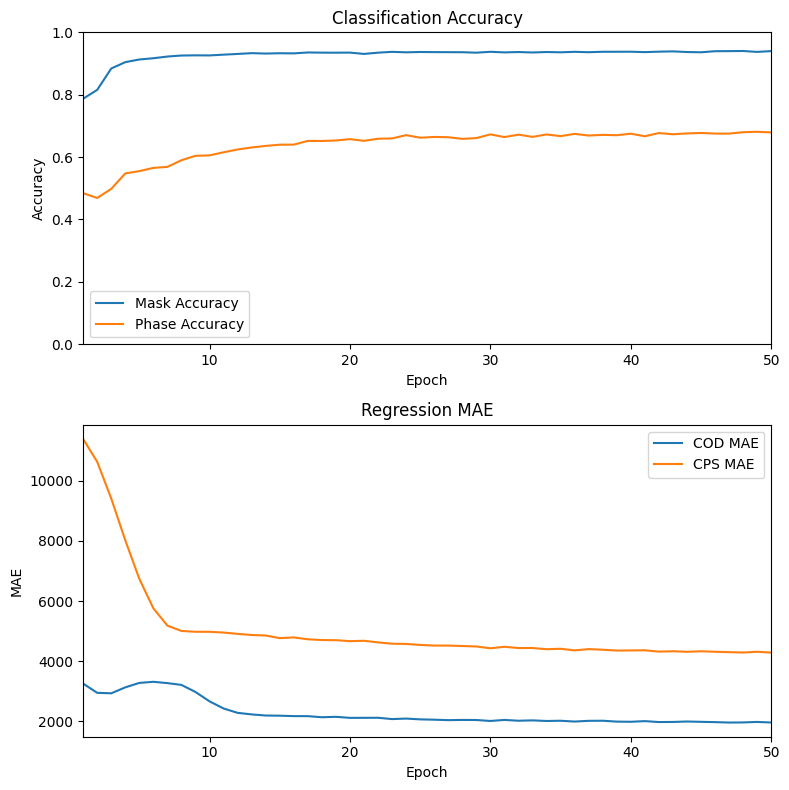

In [14]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(8, 8))

# Accuracy subplot
plt.subplot(2, 1, 1)
plt.plot(epochs, epoch_mask_acc, label='Mask Accuracy')
plt.plot(epochs, epoch_phase_acc, label='Phase Accuracy')
plt.ylim(0, 1)
plt.xlim(1, num_epochs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy")
plt.legend()

# MAE subplot
plt.subplot(2, 1, 2)
plt.plot(epochs, epoch_cod_mae, label='COD MAE')
plt.plot(epochs, epoch_cps_mae, label='CPS MAE')
plt.xlim(1, num_epochs)
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Regression MAE")
plt.legend()

plt.tight_layout()
plt.savefig("graphs/Caleb/multi-task-v1.png", dpi=300)
plt.show()
plt.close()


In [15]:
# valid_mask = df['l2_dqf_cloud_mask'].apply(lambda arr: (arr == 1).all())
# valid_phase = df['l2_dqf_cloud_phase'].apply(lambda arr: (arr == 1).all())
# valid_cod = df['l2_dqf_cod'].apply(lambda arr: (arr == 1).all())
# valid_cps = df['l2_dqf_cps'].apply(lambda arr: (arr == 1).all())

# valid_idx = valid_mask & valid_phase & valid_cod & valid_cps
# print("Valid samples:", valid_idx.sum(), "/", len(df))


In [16]:
# # for col in ['l2_dqf_cloud_mask', 'l2_dqf_cloud_phase', 'l2_dqf_cod', 'l2_dqf_cps']:
# for col in ['l2_cloud_mask', 'l2_cloud_phase', 'l2_cod', 'l2_cps']:
#     print(f"\n{col}:")
#     vals = df[col].apply(lambda x: np.unique(x, return_counts=True))
#     flat_vals = np.concatenate([v[0] for v in vals])
#     print("Unique values (merged):", np.unique(flat_vals))
